Load the dataset

In [34]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras.layers.experimental import preprocessing
from simclr import SimCLR
import tensorflow_datasets as tfds


In [2]:
import csv
import os

datapath = 'clothing-dataset/'
data = []
with open(os.path.join(datapath, 'images.csv')) as csv_file:
    reader = csv.reader(csv_file, delimiter=',')
    for line in reader:
        data.append(line)
    

In [3]:
print(data[:10])

[['image', 'sender_id', 'label', 'kids'], ['4285fab0-751a-4b74-8e9b-43af05deee22', '124', 'Not sure', 'False'], ['ea7b6656-3f84-4eb3-9099-23e623fc1018', '148', 'T-Shirt', 'False'], ['00627a3f-0477-401c-95eb-92642cbe078d', '94', 'Not sure', 'False'], ['ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa', '43', 'T-Shirt', 'False'], ['3b86d877-2b9e-4c8b-a6a2-1d87513309d0', '189', 'Shoes', 'False'], ['5d3a1404-697f-479f-9090-c1ecd0413d27', '138', 'Shorts', 'False'], ['b0c03127-9dfb-4573-8934-1958396937bf', '138', 'Shirt', 'False'], ['4c8f245e-a039-46fd-a6b9-1bb51e83fc05', '226', 'T-Shirt', 'False'], ['c995c900-693d-4dd6-8995-43f3051ec488', '337', 'Pants', 'False']]


In [4]:
labels = data[0]
data = data[1:]

In [5]:
print(labels)
print(data[:10])

['image', 'sender_id', 'label', 'kids']
[['4285fab0-751a-4b74-8e9b-43af05deee22', '124', 'Not sure', 'False'], ['ea7b6656-3f84-4eb3-9099-23e623fc1018', '148', 'T-Shirt', 'False'], ['00627a3f-0477-401c-95eb-92642cbe078d', '94', 'Not sure', 'False'], ['ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa', '43', 'T-Shirt', 'False'], ['3b86d877-2b9e-4c8b-a6a2-1d87513309d0', '189', 'Shoes', 'False'], ['5d3a1404-697f-479f-9090-c1ecd0413d27', '138', 'Shorts', 'False'], ['b0c03127-9dfb-4573-8934-1958396937bf', '138', 'Shirt', 'False'], ['4c8f245e-a039-46fd-a6b9-1bb51e83fc05', '226', 'T-Shirt', 'False'], ['c995c900-693d-4dd6-8995-43f3051ec488', '337', 'Pants', 'False'], ['bf78527f-0734-44fd-a968-f6c32c12d61e', '175', 'Shoes', 'False']]


In [6]:
num_examples = len(data)
print(len(data))

5403


In [7]:
label_counts = dict()
for row in data:
    if row[2] not in label_counts:
        label_counts[row[2]] = 0
    label_counts[row[2]] += 1
    
valid_labels = dict()
for k, v in label_counts.items():
    if v >= 100 and k not in ['Not sure', 'Others', 'Skip']:
        valid_labels[k] = v

filename_to_label = dict()
cleaned_data = []
valid_filenames = []
for i in range(len(data)):
    if data[i][2] in valid_labels.keys():
        cleaned_data.append(data[i])
        valid_filenames.append(data[i][0])
        filename_to_label[data[i][0]] = data[i][2]



num_examples = len(cleaned_data)
print(num_examples)

4961


In [8]:
import os
import shutil

imagespath = 'clothing-dataset/images'
images = [f for f in os.listdir(imagespath) if os.path.isfile(os.path.join(imagespath, f))]

num_images_moved = 0



for i in range(len(images)):
    filename = images[i].split(".")[0]
    if filename not in valid_filenames:
        continue
        
    if num_images_moved < num_train + num_validate:
        folder_name = 'train'
    else:
        folder_name = 'test'
    
    new_folder = os.path.join(imagespath, folder_name)
    
    classname = filename_to_label[filename]
    finalfoldername = os.path.join(new_folder, classname)
    
    if not os.path.exists(finalfoldername):
        os.makedirs(finalfoldername)
    
    old_image_path = os.path.join(imagespath, images[i])
    new_image_path = os.path.join(finalfoldername, images[i])
    shutil.move(old_image_path, new_image_path)
    num_images_moved += 1

In [100]:
num_train = 3600
num_validate = 900
num_test = 461
epochs = 50
batch_size = 16
train_dir = os.path.join(os.getcwd(), os.path.join(imagespath, 'train'))
img_height = 128
img_width = 128
input_shape = (128, 128, 3)
num_classes = len(valid_labels)
labels = ["Blazer", 'Dress', 'Hat', 'Hoodie', 'Longsleeve', 'Outwear', 'Pants', 'Polo', 'Shirt', 'Shoes', 'Shorts', 'Skirt', 'T-Shirt', 'Undershirt']
print(num_classes)

14


In [101]:
import random
seed = random.randint(1, 10000)
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 14 classes.
Using 3600 files for training.
Found 4500 files belonging to 14 classes.
Using 900 files for validation.


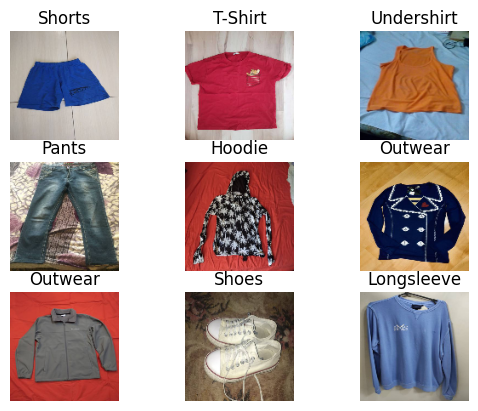

In [72]:
lmao = train_ds.take(1)
fig, ax = plt.subplots(3, 3)
for x, y in tfds.as_numpy(lmao):
    for i in range(batch_size):
        if i < 9:
            ax[i // 3, i % 3].imshow(x[i] / 255)
            ax[i // 3, i % 3].set_title(labels[y[i]])
            ax[i // 3, i % 3].axis('off')

In [102]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal_and_vertical"), 
                                         tf.keras.layers.RandomRotation(0.2),])


In [83]:
model = tf.keras.Sequential([
    data_augmentation, 
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [84]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [85]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
57/57 [==============================] - 13s 199ms/step - loss: 2.5139 - accuracy: 0.1844 - val_loss: 2.3873 - val_accuracy: 0.1956
Epoch 2/50
57/57 [==============================] - 11s 190ms/step - loss: 2.2895 - accuracy: 0.2542 - val_loss: 2.2555 - val_accuracy: 0.2744
Epoch 3/50
57/57 [==============================] - 11s 195ms/step - loss: 2.1328 - accuracy: 0.3300 - val_loss: 2.1490 - val_accuracy: 0.3278
Epoch 4/50
57/57 [==============================] - 12s 200ms/step - loss: 2.0145 - accuracy: 0.3717 - val_loss: 2.0878 - val_accuracy: 0.3489
Epoch 5/50
57/57 [==============================] - 11s 198ms/step - loss: 1.9139 - accuracy: 0.4042 - val_loss: 2.0168 - val_accuracy: 0.3911
Epoch 6/50
57/57 [==============================] - 11s 196ms/step - loss: 1.8268 - accuracy: 0.4342 - val_loss: 1.9676 - val_accuracy: 0.4189
Epoch 7/50
57/57 [==============================] - 12s 202ms/step - loss: 1.7728 - accuracy: 0.4425 - val_loss: 1.9255 - val_accuracy: 0.4189

29/29 [==============================] - 1s 16ms/step - loss: 2.1786 - accuracy: 0.4902
Test accuracy: 49.02%


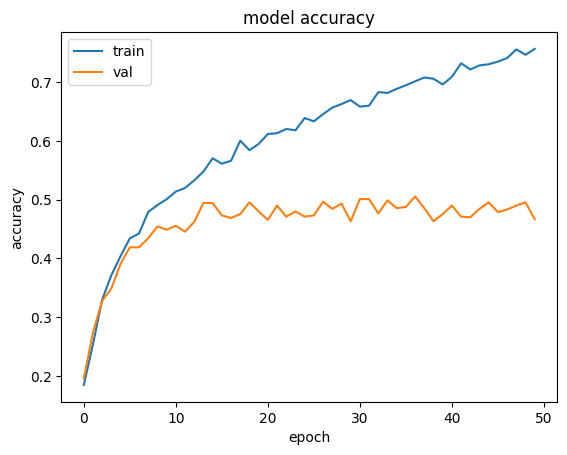

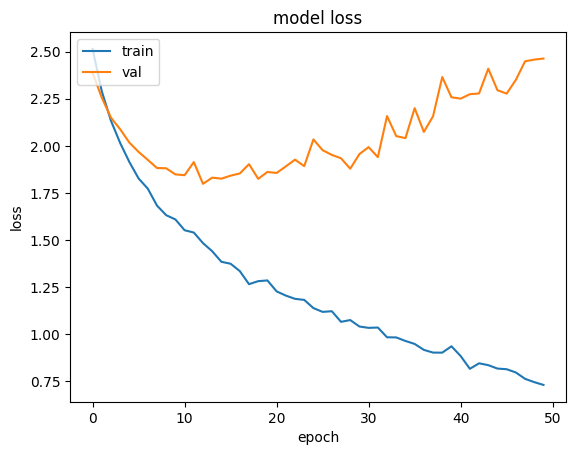

In [90]:
predictor = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])
predictor.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])
accuracy = predictor.evaluate(test_ds)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [103]:
test_dir = os.path.join(os.getcwd(), os.path.join(imagespath, 'test'))
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 461 files belonging to 14 classes.


In [ ]:
def create_encoder():
    transfer_model = tf.keras.Sequential()
    resnet50 = tf.keras.applications.ResNet50V2(include_top=False,
                       input_shape=(img_height,img_width,3),
                       pooling='avg',classes=num_classes,
                       weights='imagenet')

    


    transfer_model.add(data_augmentation)

    transfer_model.add(resnet50)
    return transfer_model


def create_classifier(encoder, trainable=True):
    for layer in encoder.layers:
        layer.trainable=trainable
    encoder.add(Dropout(0.1))
    encoder.add(Flatten())
    encoder.add(Dense(128, activation='relu'))
    encoder.add(Dropout(0.1))
    encoder.add(Dense(num_classes))
    return encoder

    
    


In [111]:
transfer_model = tf.keras.Sequential()
resnet50 = tf.keras.applications.ResNet50V2(include_top=False,
                    input_shape=(img_height,img_width,3),
                    pooling='avg',classes=num_classes,
                    weights='imagenet')


transfer_model.add(data_augmentation)

for layer in resnet50.layers:
    layer.trainable = False

transfer_model.add(resnet50)
transfer_model.add(Flatten())
transfer_model.add(tf.keras.layers.BatchNormalization())
transfer_model.add(Dense(128, activation='relu'))
transfer_model.add(Dropout(0.1))
transfer_model.add(tf.keras.layers.BatchNormalization())
transfer_model.add(Dense(num_classes))


In [112]:

transfer_model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
history = transfer_model.fit(train_ds, validation_data=val_ds, epochs=epochs)


Epoch 1/50
225/225 [==============================] - 64s 273ms/step - loss: 2.5129 - accuracy: 0.2456 - val_loss: 2.4486 - val_accuracy: 0.2678
Epoch 2/50
225/225 [==============================] - 60s 267ms/step - loss: 2.1386 - accuracy: 0.3242 - val_loss: 2.3820 - val_accuracy: 0.2733
Epoch 3/50
225/225 [==============================] - 59s 264ms/step - loss: 2.0231 - accuracy: 0.3597 - val_loss: 2.3696 - val_accuracy: 0.2778
Epoch 4/50
225/225 [==============================] - 60s 265ms/step - loss: 1.9653 - accuracy: 0.3714 - val_loss: 2.4442 - val_accuracy: 0.2589
Epoch 5/50
225/225 [==============================] - 60s 265ms/step - loss: 1.8918 - accuracy: 0.4036 - val_loss: 2.4830 - val_accuracy: 0.2689
Epoch 6/50
225/225 [==============================] - 59s 264ms/step - loss: 1.8581 - accuracy: 0.3947 - val_loss: 2.4920 - val_accuracy: 0.2656
Epoch 7/50
225/225 [==============================] - 59s 264ms/step - loss: 1.8320 - accuracy: 0.4200 - val_loss: 2.4978 - val_ac

29/29 [==============================] - 6s 205ms/step - loss: 2.6391 - sparse_categorical_accuracy: 0.0369
Test accuracy: 3.69%


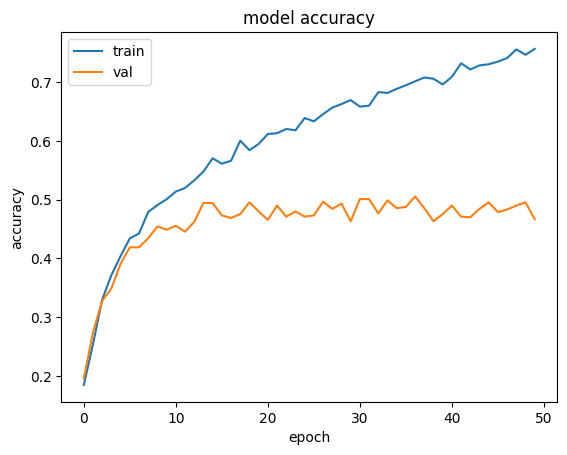

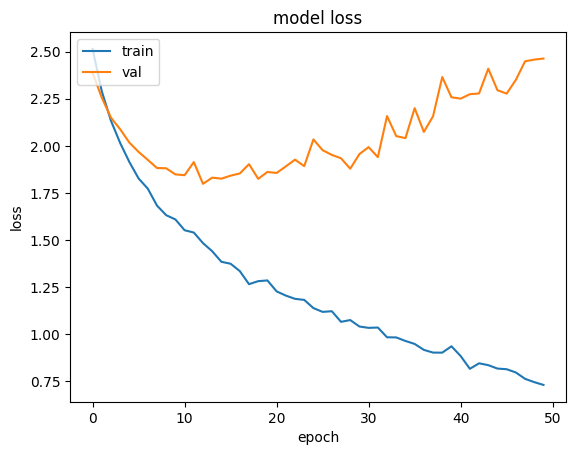

In [92]:
accuracy = classifier.evaluate(test_ds)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [45]:
evaluation = transfer_model.evaluate(test_ds)

29/29 [==============================] - 6s 222ms/step - loss: 1.0124 - accuracy: 0.7007


In [34]:
labels = ["Blazer", 'Dress', 'Hat', 'Hoodie', 'Longsleeve', 'Outwear', 'Pants', 'Polo', 'Shirt', 'Shoes', 'Shorts', 'Skirt', 'T-Shirt', 'Undershirt']
len(labels)

14

In [43]:
pred_labels = np.argmax(predictions, axis=1)
pred_classes = np.array(labels)[pred_labels]


NameError: name 'predictions' is not defined

In [44]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="cifar-encoder_with_projection-head"
    )
    return model

In [46]:
learning_rate = 0.01
temperature = 0.05
projection_units = 128

In [47]:
encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_with_projection_head.summary()

epochs = 15

history = encoder_with_projection_head.fit(
    train_ds, validation_data=val_ds, batch_size=batch_size, epochs=epochs
)

classifier = create_classifier(encoder, trainable=False)

classifier.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

epochs = 15

history = classifier.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs=epochs)



Model: "cifar-encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 2048)              23564800  
                                                                 
 dense_26 (Dense)            (None, 128)               262272    
                                                                 
Total params: 23,827,072
Trainable params: 23,781,632
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/15
57/57 [==============================] - 190s 3s/step - loss: 4.1183 - val_loss: 4.1466
Epoch 2/15
57/57 [==============================] - 186s 3s/step - loss: 4.0936 - val_loss: 4.1464
Epoch 3/15
57/57 [==============================] - 187s 3s/step - loss: 4.0921 -

In [91]:
predictor = tf.keras.Sequential([classifier, tf.keras.layers.Softmax()])

predictor.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

accuracy = classifier.evaluate(test_ds)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

29/29 [==============================] - 6s 205ms/step - loss: 2.6391 - sparse_categorical_accuracy: 0.0369
Test accuracy: 3.69%


In [35]:
Algorithm = SimCLR

width = 128
num_epochs = 10

hyperparams = {SimCLR: {"temperature": 0.1}}

# architecture
model = Algorithm(
    contrastive_augmenter=keras.Sequential(
        [
            layers.Input(shape=(img_width, img_height, 3)),
            preprocessing.Rescaling(1 / 255),
            preprocessing.RandomFlip("horizontal"),
            
        ],
        name="contrastive_augmenter",
    ),
    classification_augmenter=keras.Sequential(
        [
            layers.Input(shape=(img_width, img_height, 3)),
            preprocessing.Rescaling(1 / 255),
            preprocessing.RandomFlip("horizontal"),
            
        ],
        name="classification_augmenter",
    ),
    encoder=keras.Sequential(
        [
            layers.Input(shape=(img_width, img_height, 3)),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Conv2D(width, kernel_size=3, strides=2, activation="relu"),
            layers.Flatten(),
            layers.Dense(width, activation="relu"),
        ],
        name="encoder",
    ),
    projection_head=keras.Sequential(
        [
            layers.Input(shape=(width,)),
            layers.Dense(width, activation="relu"),
            layers.Dense(width),
        ],
        name="projection_head",
    ),
    linear_probe=keras.Sequential(
        [
            layers.Input(shape=(width,)),
            layers.Dense(num_classes),
        ],
        name="linear_probe",
    ),
    **hyperparams[Algorithm],
)

In [38]:
model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

# run training

np_train_ds = tfds.as_numpy(train_ds)
np_val_ds = tfds.as_numpy(val_ds)


    
history = model.fit(np_train_ds, epochs=num_epochs, validation_data=np_val_ds)

(array([[[[178.       ,  45.       ,  46.       ],
         [179.77295  ,  46.77295  ,  47.77295  ],
         [181.       ,  48.       ,  49.       ],
         ...,
         [167.66406  , 175.80469  , 152.73438  ],
         [157.37256  , 167.85693  , 144.34131  ],
         [166.146    , 178.146    , 156.146    ]],

        [[179.10986  ,  46.109863 ,  47.109863 ],
         [181.14209  ,  48.14209  ,  49.14209  ],
         [181.       ,  48.       ,  49.       ],
         ...,
         [160.96631  , 169.10693  , 146.03662  ],
         [153.58691  , 164.07129  , 140.55566  ],
         [164.47607  , 176.47607  , 154.47607  ]],

        [[180.4956   ,  47.495605 ,  48.495605 ],
         [182.3125   ,  49.3125   ,  50.3125   ],
         [180.73145  ,  47.731445 ,  48.731445 ],
         ...,
         [158.6914   , 166.83203  , 143.76172  ],
         [157.67773  , 168.16211  , 144.64648  ],
         [164.64697  , 176.64697  , 154.64697  ]],

        ...,

        [[214.41406  ,  66.41406  ,  

ValueError: Failed to find data adapter that can handle input: <class 'tensorflow_datasets.core.dataset_utils._IterableDataset'>, <class 'NoneType'>